In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os
from src import *


2023-04-28 15:56:06.028288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 15:56:06.602017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 15:56:06.602091: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-28 15:56:08.588999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


CONVOLUTION_LAYERS = 5

## Load data

In [3]:
# data_filename_list = ["Data", "wig20_d.csv"]
# data_filename_list = ["Data", "2_Extracted", "Crude_Oil_5.csv"]
data_filename_list = ["Data", "2_Extracted", "Tesla_5.csv"]

_df = pd.read_csv(os.path.join(*data_filename_list), index_col=0)
# _df = pd.read_csv("Data/wig20_d.csv")
# _df = pd.read_csv("Data/mwig40_d.csv")
# _df = pd.read_csv("Data/swig80_d.csv")

# _df.drop(range(1000), inplace=True)
_df.reset_index(inplace=True, drop=True)
_df.head()

,O,H,L,C,Volume
0,832.07,838.98,821.77,821.77,3503000.0
1,820.90,823.98,807.81,810.21,1712000.0
2,809.47,813.75,803.00,803.00,1305000.0
3,804.00,806.53,793.40,801.51,2133000.0
4,802.00,809.97,796.75,806.60,1190000.0


In [4]:
data = _df.drop(columns=["Data"], errors="ignore").values.transpose()
data.shape

(5, 5312)

## Process and split data

In [5]:
# thr_fall, thr_rise = (-0.005270574305918364, 0.004968199728502841)
thr_fall, thr_rise = (-0.001, 0.001)

data_pipeline = DataProcess(
    data, test_ratio=0.07, validation_ratio=0.05, batch_size=3**(CONVOLUTION_LAYERS-2),
    threshold_fall=thr_fall, threshold_rise=thr_rise, feature_to_predict_num=3,
    balance_training_dataset=True
)
data_pipeline.run()
_x_train, _y_train, _x_validation, _y_validation, _x_test, _y_test = data_pipeline.get_data()
_y_test_ind, _y_validation_ind = np.argmax(_y_test, axis=1), np.argmax(_y_validation, axis=1)


In [6]:
pd.DataFrame(
    {
        "x": [_x_train.shape, _x_validation.shape, _x_test.shape],
        "y": [_y_train.shape, _y_validation.shape, _y_test.shape]
    },
    index = ["train", "validation", "test"]
)


,x,y
train,"(4572, 5, 27, 2)","(4572, 3)"
validation,"(313, 5, 27, 2)","(313, 3)"
test,"(345, 5, 27, 2)","(345, 3)"


In [7]:
print("Train dataset classes value counts:")
_y_train.sum(axis=0)
# pd.DataFrame(
#     {
#         str(key): val for (key, val) in zip(*np.unique(np.argmax(_y_train, axis=1), return_counts=True))
#     },
#     index = ["count"]
# )

Train dataset classes value counts:


array([1524, 1524, 1524])

## Model

### Building

In [23]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=_x_train.shape[1:]))
for i in range(CONVOLUTION_LAYERS):
    model.add(tf.keras.layers.Conv2D(2, (1, 3), 1, padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1, 3), strides=(1, 3), padding='same'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation="relu"))
model.add(tf.keras.layers.Dense(500, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="softmax"))


In [24]:
model.build(input_shape=_x_train.shape[1:])

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 5, 27, 2)          14        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 9, 2)          0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 5, 9, 2)           14        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 3, 2)          0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 3, 2)           14        
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 1, 2)         

In [26]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#               loss=f1_m,
#               metrics=f1_m
#               )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=f1_m
              )


In [27]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      min_delta=1e-3,
                                      patience=500,
                                      start_from_epoch=500,
                                      )
# es = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m',
#                                       mode='max',
#                                       min_delta=1e-3,
#                                       patience=200,
#                                       start_from_epoch=200,
#                                       )
# mc = tf.keras.callbacks.ModelCheckpoint('Models/cdt_2/best_model.h5',
#                                         monitor='val_loss',
#                                         mode='min'
#                                         )
# mc = tf.keras.callbacks.ModelCheckpoint('Models/cdt_2/best_model.h5',
#                                         monitor='val_f1_m',
#                                         mode='max'
#                                         )

history = model.fit(_x_train, _y_train,
                    epochs=1000,
                   # callbacks=[es, mc],
                #    callbacks=[es],
                   validation_data=(_x_validation, _y_validation),
                    )


Epoch 1/1000
143/143 [==============================] - 6s 18ms/step - loss: 1.0976 - f1_m: 8.4764e-04 - val_loss: 1.1040 - val_f1_m: 0.0000e+00
Epoch 2/1000
143/143 [==============================] - 2s 15ms/step - loss: 1.0954 - f1_m: 0.0029 - val_loss: 1.0851 - val_f1_m: 0.0000e+00
Epoch 3/1000
143/143 [==============================] - 2s 15ms/step - loss: 1.0945 - f1_m: 0.0013 - val_loss: 1.0990 - val_f1_m: 0.0000e+00
Epoch 4/1000
143/143 [==============================] - 2s 16ms/step - loss: 1.0918 - f1_m: 0.0169 - val_loss: 1.1092 - val_f1_m: 0.0071
Epoch 5/1000
143/143 [==============================] - 3s 22ms/step - loss: 1.0917 - f1_m: 0.0232 - val_loss: 1.0891 - val_f1_m: 0.0000e+00
Epoch 6/1000
143/143 [==============================] - 3s 19ms/step - loss: 1.0921 - f1_m: 0.0041 - val_loss: 1.0856 - val_f1_m: 0.0000e+00
Epoch 7/1000
143/143 [==============================] - 3s 21ms/step - loss: 1.0907 - f1_m: 4.2382e-04 - val_loss: 1.0857 - val_f1_m: 0.0000e+00
Epoch 8/1

In [28]:
model.save(os.path.join("Models", "CDT_1D", data_filename_list[-1][:-4]))

INFO:tensorflow:Assets written to: Models/CDT_1D/Tesla_5/assets


INFO:tensorflow:Assets written to: Models/CDT_1D/Tesla_5/assets


### Evaluating

### Valitation

In [29]:
model.evaluate(_x_validation, _y_validation)

10/10 [==============================] - 0s 6ms/step - loss: 5.5324 - f1_m: 0.2827


[5.532393932342529, 0.2826770544052124]

In [30]:
pred_validation = model.predict(_x_validation)
pred_validation_ind = np.argmax(pred_validation, axis=1)

10/10 [==============================] - 0s 6ms/step


In [31]:
print("Validation correct:", np.sum(pred_validation_ind == _y_validation_ind))
print("Validation accuracy:", np.sum(pred_validation_ind == _y_validation_ind)/pred_validation_ind.shape[0])

Validation correct: 101
Validation accuracy: 0.3226837060702875


In [32]:
confusion_matrix(_y_validation_ind, pred_validation_ind)

array([[39, 48, 72],
       [ 8, 21, 35],
       [27, 22, 41]])

### Test

In [33]:
model.evaluate(_x_test, _y_test)

11/11 [==============================] - 0s 7ms/step - loss: 75.4104 - f1_m: 0.2900


[75.41040802001953, 0.28999006748199463]

In [34]:
pred_test = model.predict(_x_test)
pred_test_ind = np.argmax(pred_test, axis=1)

11/11 [==============================] - 0s 8ms/step


In [35]:
print("Test correct:", np.sum(pred_test_ind == _y_test_ind))
print("Test accuracy:", np.sum(pred_test_ind == _y_test_ind)/pred_test_ind.shape[0])

Test correct: 102
Test accuracy: 0.2956521739130435


In [36]:
confusion_matrix(_y_test_ind, pred_test_ind)

array([[ 21,  14,  78],
       [ 17,   6, 117],
       [ 12,   5,  75]])

In [37]:
history.history.keys()

dict_keys(['loss', 'f1_m', 'val_loss', 'val_f1_m'])

<Axes: >

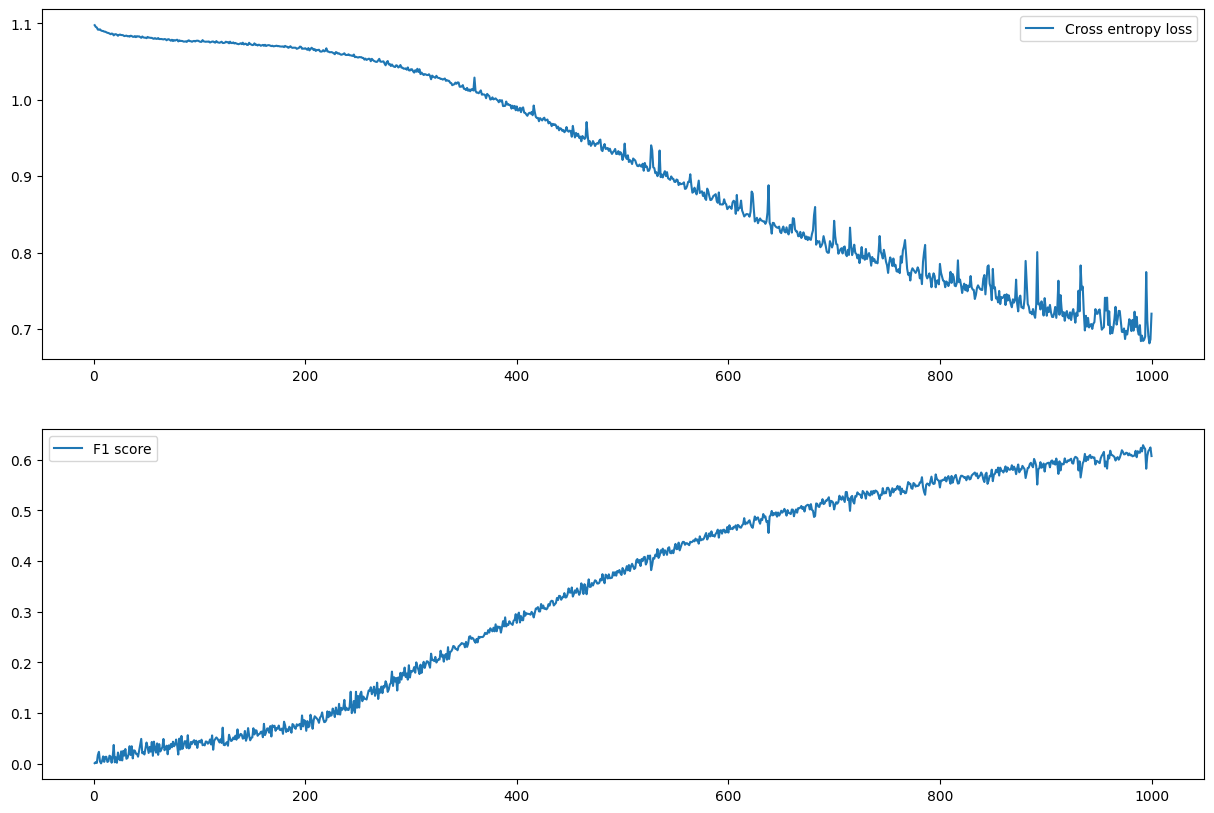

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))
sns.lineplot(x=np.arange(len(history.history["loss"]))+1, y=history.history["loss"], ax=ax[0], label="Cross entropy loss")
sns.lineplot(x=np.arange(len(history.history["f1_m"]))+1, y=history.history["f1_m"], ax=ax[1], label="F1 score")


# Draft

In [22]:
a = np.broadcast_to(np.arange(10).reshape((1, 1, -1, 1)), (50, 1, 10, 2))


2023-04-08 17:42:32.113045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 17:42:32.578295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-08 17:42:32.578332: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-08 17:42:34.321777: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-